This presentation has very wide content; resize your window to view it.
This line ensures content follows thenew window size, and inhibits line wrap.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#display(HTML("<style>.div.output_area pre { white-space: pre; }</style>")) # didn't work

## [https://github.com/AsgardSystems/qante](https://github.com/AsgardSystems/qante) 
## [pyPI](https://pypi.org/project/qante/) &nbsp; `pip install qante`

## [Example 1](#example1) &nbsp;[Example 2](#example2) &nbsp; [Conclusions](#conclusions) &nbsp; [API Documentation](#apidoc) &nbsp; [Other Documentation](#other-doc)

<a id="example1"></a>

<a id="example1"></a>

# Example 1: Extract emails, dates, and times <br/> from email headers in email body (in <font color='green'>green</font>) 

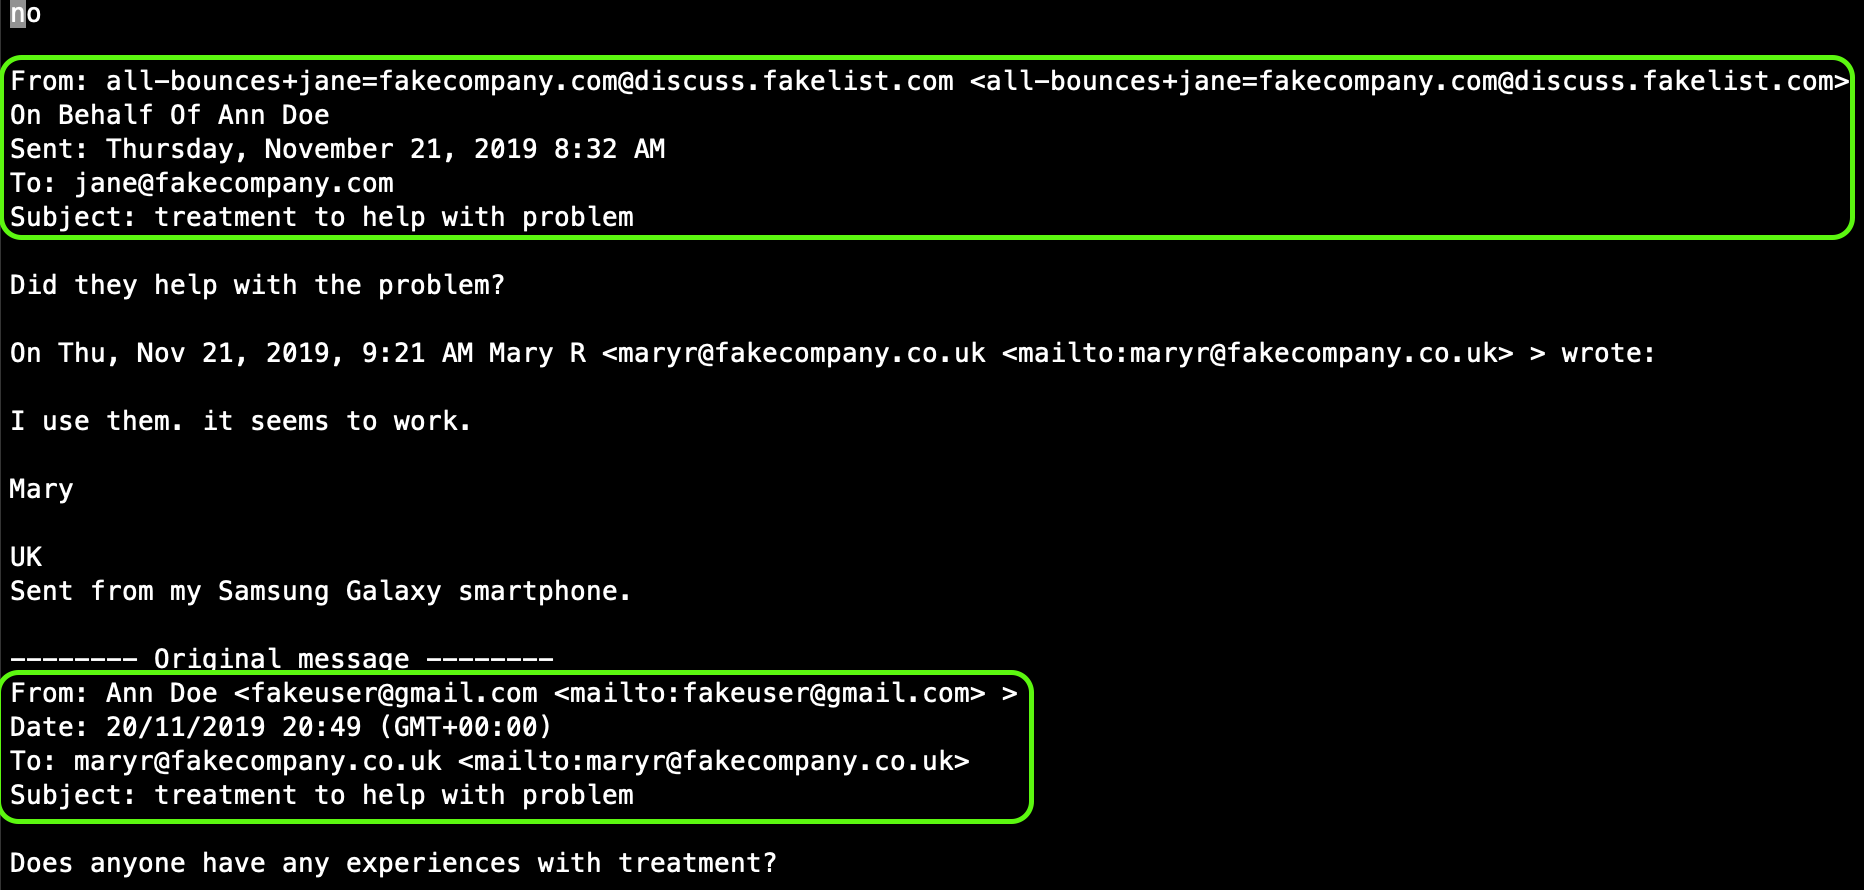


## Import our package and the items we need

In [2]:
import qante                        # pip install qante
import qante.loctuple as lt          # for query relation docstrings
from qante.tagger import Tagger,lit  # Tagger class and lit() function
from qante.query import Query        # Function to query Tagged text

## Import regular expressions used by our examples 

In [3]:
from jn_regex import DATE,TIME,EMAIL # local module w/regexps for date, time, email

## Read the text and construct a Tagger for it

In [4]:
# create tagged text object from file
f = open( 'email.txt', 'r')
text = f.read() 
tagged_email = Tagger(text)          # converts to lowercase by default
f.close()

## Tag the text with locations for <br/> &nbsp; *dates*, *times*, *emails*,  and `sent:` or `date:`

In [5]:
if not tagged_email.get_locs('SENTDATETIME'):  # allow re-exection of cell w/o error
    
    # tag locations of dates, times, and emails using their regexp's
    tagged_email.tagRE('DATE', DATE)     # e.g. Thursday, November 21, 2019
    tagged_email.tagRE('TIME', TIME)     # e.g. 8:31 AM, 9:21 AM, 20:49 (GMT+00:00)
    tagged_email.tagRE('EMAIL', EMAIL)   # e.g. fakeuser@gmail.com
    # tagRE takes a tag name and regular expression (re) and 
    # tags all locations in the document that match that re.
    
    # Some headers use "Sent:" instead of "Date:"
    tagged_email.tagRE('SENTDATETIME', '(sent:)|(date:)')

## Specify the tags and the predicate referencing them

In [6]:
# tags is an ordered sequence of 9 tags:
tags = [lit('from:'),  'EMAIL',  lit('>'),     # 0,1,2
    'SENTDATETIME', 'DATE', 'TIME',            # 3,4,5
    lit('to:'),  'EMAIL',                      # 6,7
    lit('subject:')                            # 8
] # tag names appear in quotes, literal strings appear in lit()

# referenced by their positions in this predicate:
pred = ('seq_before_meets(0,1,2,3,4,5,6,7,8)'  # tags in order (possibly adjacent)
    ' and dist(0,8) < 350'                     # 'from:' within 350 chars of 'subject:'
    ' and dist(1,2) < 5'                       #  [from] EMAIL within 5 chars of '>'
    ' and dist(6,7) < 5')                      # 'to:' within 5 chars of [to] EMAIL

<big>See [API Documentation](#apidoc) below:
Query class for: [Query Sytax](#query-doc) and 
loctuple module for [predicates](#lt-doc) </big>  

<br/>

<big>
dist(0,8) < 350 prevents one header matching content from another<br/>
dist(1,2) < 5 selects only the last email address after 'from:'<br/>
dist(6,7) < 5 selects only the first email address after 'to:'<br/>
</big>


## Create and execute the query, which returns a sequence of 4-tuples

In [7]:
qry = Query(tags, pred, tagged_email, [1,4,5,7])  # (from_email, date, time, to_email)
quadruplets = qry.execute()
tagged_email.display_tuples(quadruplets)

('all-bounces+jane=fakecompany.com@discuss.fakelist.com', 'thursday, november 21, 2019', '8:32 am', 'jane@fakecompany.com')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')


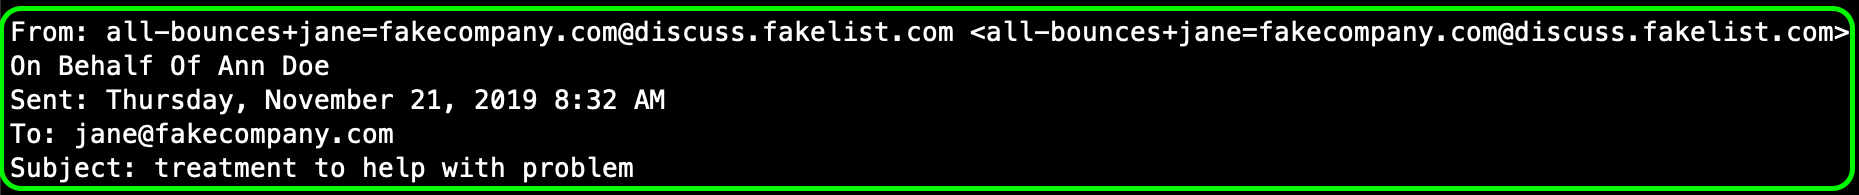

## duplicate rows appear above because "to:" appears twice: <br/> &nbsp; in `To:` and `mailto:`

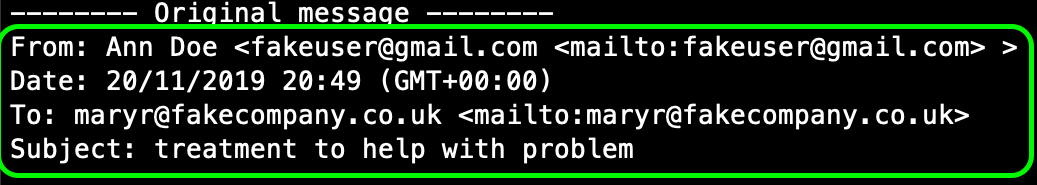

## To skip the `to:` in `mailto:`, we chose to use a <br/> &nbsp; user-defined-predicate (UDP) <br/> that returns False if text preceeding location is 'mail'

In [8]:
pred = ('seq_before_meets(0,1,2,3,4,5,6,7,8)'    # tags must appear in order
    ' and dist(0,8) < 350 and dist(1,2) < 5 and dist(6,7) < 5'
    ' and not_preceeded_by_mail(6)') # this UDP has one Loc parm: index 6 ('to:')
qry = Query(tags, pred, tagged_email, [1,4,5,7])
qry.UDP('not_preceeded_by_mail',  # UDPs expect a tuple of Loc ations
    lambda locs: not (
        tagged_email.text[locs[0].start()-4:].startswith('mail'))
)
quads = qry.execute()
tagged_email.display_tuples(quads)


('all-bounces+jane=fakecompany.com@discuss.fakelist.com', 'thursday, november 21, 2019', '8:32 am', 'jane@fakecompany.com')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')


<a id="example2"></a>

# Example 2: Extracting Tables From Text Layouts

## We want to extract a table (shown in green) from electric bills:

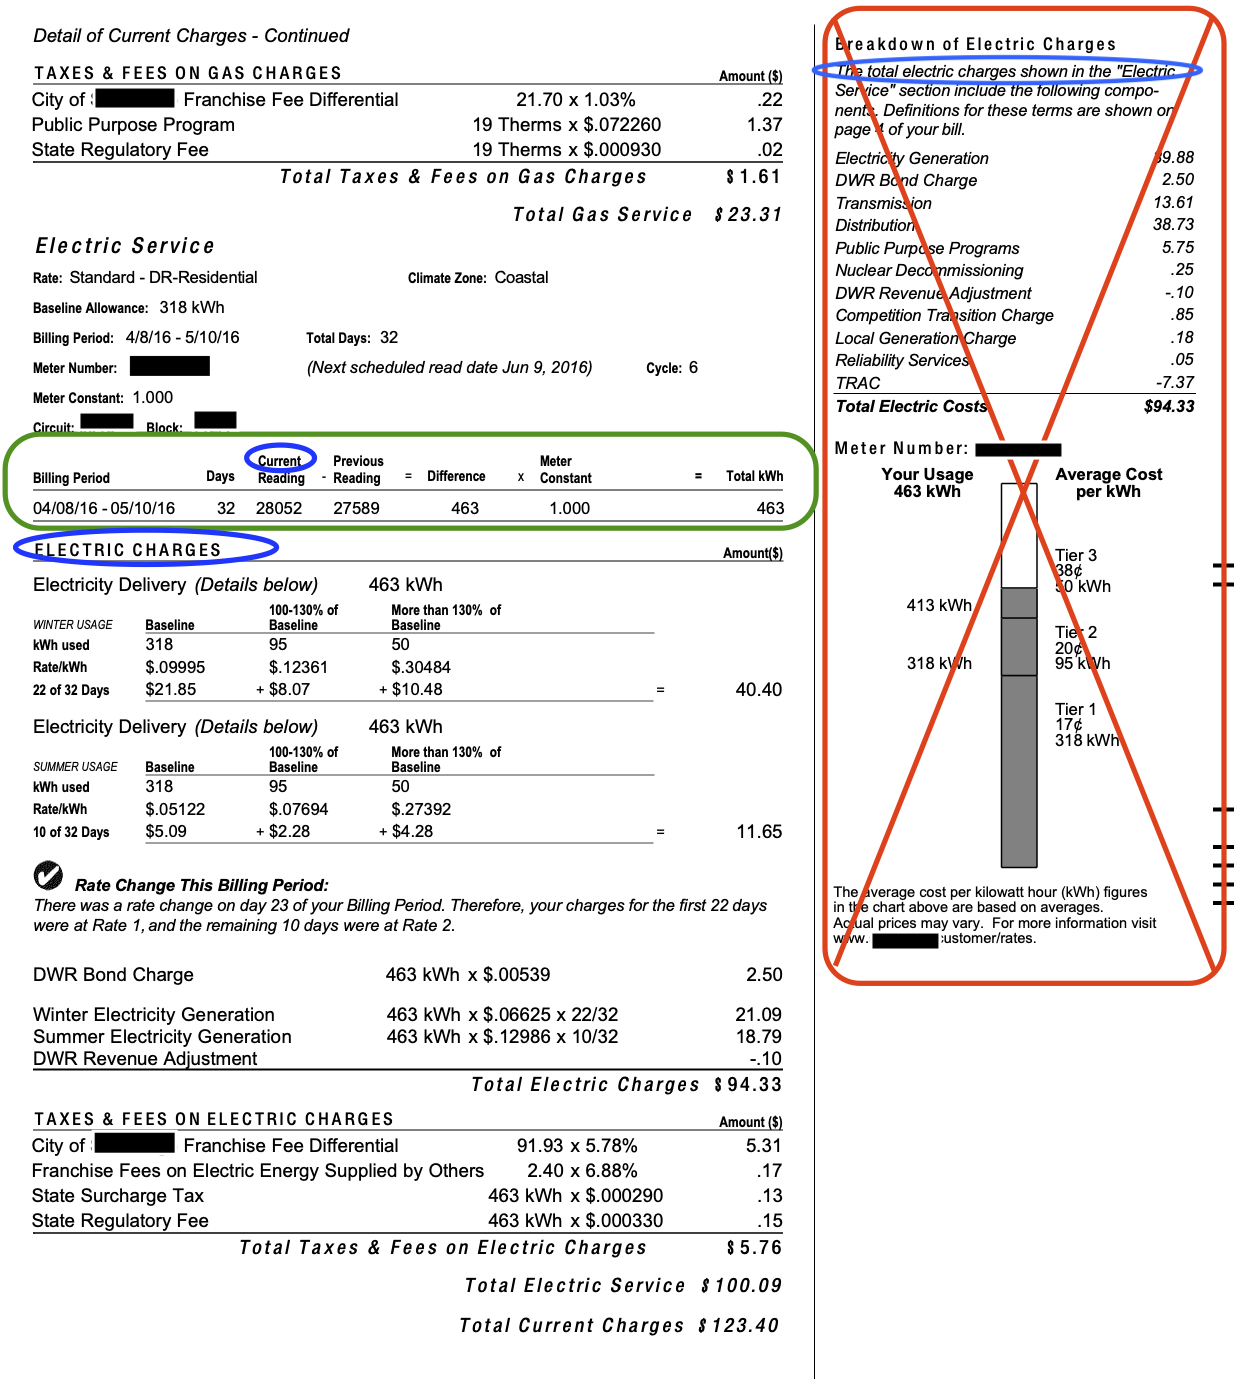

###  Read text from one page of the bill (from  `pdftotext -layout`)

In [9]:
import qante.utilities as ut   # get_column, LINE
f = open('bill.txt')
text = f.read() 

In [10]:
print(text[0:2000])  # very wide output (resize window to see it)

Detail of Current Charges - Continued                                                                                  Breakdown of Electric Charges
TAXES & FEES ON GAS CHARGES                                                                               Amount ($)   The total electric charges shown in the "Electric
                                                                                                                       Service" section include the following compo-
City of xxxxxxxxx Franchise Fee Differential      21.70 x 1.03%                                               .22
                                                                                                                       nents. Definitions for these terms are shown on
Public Purpose Program                       19 Therms x $.072260                                            1.37      page 4 of your bill.
State Regulatory Fee                         19 Therms x $.000930                               

## Remove column on right (in red) 

1. <big>find locations of all text in same column as '*the total...electric*' [shown in <font color='blue'>blue</font>] (`get_column`)</big>
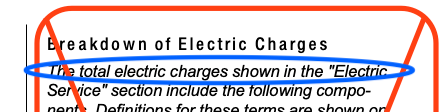
2. <big>tag them as NOISE (`tag_list`)</big>
3. <big>return text with tagged text deleted (`replace_tag`)</big>

* <big>See doctrings of each function for details: shift-tab(on *name*) or help(*name*)</big>


In [11]:
bill = Tagger(text)
str_in_column = 'the total electric charges shown in the "electric'
bill.tag_list('NOISE', ut.get_column(bill.text, str_in_column))
clean_elec_txt = bill.replace_tag('NOISE', '')
print(clean_elec_txt[0:2000])

detail of current charges - continued                                                                                  
taxes & fees on gas charges                                                                               amount ($)   
                                                                                                                       
city of xxxxxxxxx franchise fee differential      21.70 x 1.03%                                               .22
                                                                                                                       
public purpose program                       19 therms x $.072260                                            1.37      
state regulatory fee                         19 therms x $.000930                                             .02                                
                            total taxes & fees on gas charges                                              $1.61                            

## Import modules

In [12]:
from qante.loctuple import open_right_span
from qante.loclist import shortest
from qante.table import get_table

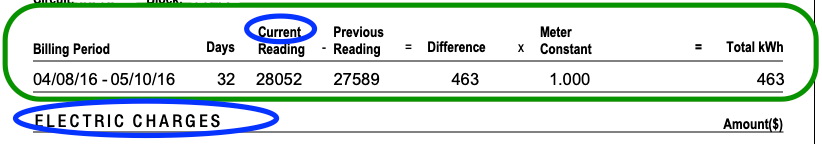

## Fetch content of desired table (in <font color='green'>green</font>)

1. <big>tag all `LINE`s in the document (`tagRE`)</big>
2. <big>get location of line containing "<font color="blue">current</font>"(`subinterval`) `before` "<font color='blue'>electric charges</font>"</big>
3. <big>return the locations of that line and  "<font color='blue'>electric charges</font>" (`pairs`)</big>
4. <big>select the text from start of line containing "<font color='blue'>current</font>" upto "<font color='blue'>electric charges</font>" (`open_right_span`)</big>
5. <big>choose the `shortest` one (there may have been others; e.g. from multiple pages)</big>

In [13]:
elec = Tagger(clean_elec_txt)
elec.tagRE('LINE', ut.LINE)

tags = ['LINE', lit('current'), lit('electric charges')]   # 0,1,2

qry = Query(tags, 'subinterval(1, 0) and before(0, 2)', elec, [0,2])
pairs = qry.execute()

locs = shortest(list(map(open_right_span, pairs)))
table_txt = elec.get_text_loc(locs[0])
print(table_txt)

                                   current       previous                           meter
billing period              days   reading     - reading      =   difference    x   constant          =    total kwh                           
                                                                                                                                                    
04/08/16 - 05/10/16          32    28052         27589                463             1.000                    463




## Extract cells from table  text (`get_table`)

In [14]:
mytable = get_table(table_txt, 2)   # top two lines are the header
print(mytable)

[{'billing period': '04/08/16 - 05/10/16', 'days': '32', 'current reading': '28052', 'previous - reading': '27589', 'difference': '463', 'meter constant': '1.000', 'total kwh': '463'}]


## result is a list of dictionaries with keys taken from the header

***
<a id="conclusions"></a>

# Conclusions

- <big><b>Provide a tool for data extraction from text</b></big>
- <big><b>Specify data extraction in a declarative manner (tags, and queries)</b></big>
- <big><b>Provide functionality for most commonly used data extraction tasks</b></big>
- <big><b>Allow specification of new functionality in a high level of abstraction</b></big>
  - when upstream text changes format, it's easy to change the code
- <big><b>Facilitate maintenance of data extraction code</b></big>
  - the code is short, easy to understand, write, and change

***


## [Example 1](#example1) &nbsp;[Example 2](#example2) &nbsp; [Other Documentation](#other-doc)

<a id="apidoc"></a>


# API Documentation

<a id="query-doc"></a>
## Query Syntax

In [15]:
from qante.query import Query
help(Query)  # query langage syntax; user-defined predicates (UDP), execute()

Help on class Query in module qante.query:

class Query(builtins.object)
 |  Class for querying tagged text
 |  
 |  Constructor Parameters:
 |  
 |     tags (string/literal list) -- list of tags or literals used by query
 |  
 |     query (string) -- query to be executed. It must follow this syntax:
 |        query  ::= '(' query ')' | conj | disj | term
 |        conj   ::= term 'and' query
 |        disj   ::= term 'or' query
 |  
 |        term   ::= pred '(' params ')'
 |        params ::= int ',' params | int
 |  
 |        term   ::= 'dist(' int ',' int ')' relop int
 |        relop  ::= '<' | '>' | '=' | '<=' | '>=' | '!='
 |  
 |        pred   ::= allen_relation | other-relation
 |  
 |        allen-relation ::= 'before' | 'meets'
 |           | 'during' | 'finishes' | 'starts' | 'equal' | 'overlaps'
 |  
 |        other-relation ::= 'subinterval' | 'intersects' | 'disjoint'
 |           | 'seq_before' | 'seq_before_meets' | 'seq_meets'
 |  
 |     tagger (Tagger Object) -- ta

<a id="lt-doc"></a>
## Predicates

In [16]:
from qante import loctuple as lt
help(lt)    # available predicate relations
# (e.g. before, meets, subinterval, seq_before, seq_before_meets, open_right_span)

Help on module qante.loctuple in qante:

NAME
    qante.loctuple - Module that implements relations and functions on location tuples

DESCRIPTION
    Allen's relations:
       before(Loc tuple) -> boolean
       meets(Loc tuple) -> boolean
       overlaps(Loc tuple) -> boolean
       starts(Loc tuple) -> boolean
       during(Loc tuple) -> boolean
       finishes(Loc tuple) -> boolean
       equal(Loc tuple) -> boolean
    Other relations:
       seq_meets(Loc tuple) -> boolean
       seq_before(Loc tuple) -> boolean
       seq_before_meets(Loc tuple) -> boolean
       subinterval(Loc tuple) -> boolean
       intersects(Loc tuple) -> boolean
       dijoint(Loc tuple) -> boolean
       
    This module also defines functions that map location tuples into a location or a tuple location
       closed_span(Loc tuple) -> Loc
       open_right_span(Loc tuple) -> Loc
       open_left_span(Loc tuple) -> Loc
       open_span(Loc tuple) -> Loc
       last(Loc tuple) -> Loc
       first(Loc tuple

In [17]:
from qante.tagger import Tagger
help(Tagger)       # e.g. tagRE, text, get_locs
                   # get_text_loc, display_tuples, replace_tag, tag_list
help(qante.tagger.lit)

Help on class Tagger in module qante.tagger:

class Tagger(builtins.object)
 |  Constructor parameters:
 |     text (string) -- text to be tagged
 |     lower_case (boolean) -- if True, convert text to lower case (default True) 
 |     
 |  Locations associated with a tag are always sorted by fr,to,offset
 |  
 |  Methods defined here:
 |  
 |  __init__(self, text, lower_case=True)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  apply_tags(self, tags)
 |      show text resulting from replacing text associated with tags 
 |      in list <tags> by the corresponding tags enclosed by char ~
 |  
 |  between(self, startTag, endTag, distance)
 |  
 |  del_tag(self, tag)
 |      Delete tag
 |      
 |      Parameters:
 |         tag (string) -- tag to be deleted
 |  
 |  display_doc(self)
 |      display entire text
 |  
 |  display_matches(self)
 |      Prints tagged strings with their respective tags
 |  
 |  display_tag(self, tag)
 |      Display strings tag

In [18]:
import qante.utilities as ut
help(ut)           # utilities: e.g. regexp LINE, function get_column()

Help on module qante.utilities in qante:

NAME
    qante.utilities - Module with common regular expressions and useful functions:

DESCRIPTION
    Regular Expressions:
       LINE
       INT
       DECIMAL
       FIELD
       altFIELD
       PAGE
    Functions:   
       get_column(string, string) -> Loc list
       cluster(Loc list) -> List of Loc lists
       get_list_span(Loc list) -> Loc

FUNCTIONS
    categorize(clusters, categories)
        Parameters
        ----------
        clusters :  a list of clusters (locations lists)
                    each cluster is sorted by txt_order()
                    clusters = [ cluster_1, .... , cluster_n ] where
                    cluster_i = [loc_1, ...., loc_o]
        categories : a list of categories (locations lists)
                     each category is sorted by txt_order()
                     categories = [ category_1, ... , category_m ]
                     category_j = [loc_1, ..., loc_l]
        
        Returns
        -------


In [19]:
from qante.loc import Loc
help(Loc)           # locations: start, end 

Help on class Loc in module qante.loc:

class Loc(builtins.object)
 |  Location
 |  
 |  Constructor Parameters:
 |     fr (int) -- start position of interval with respect to offset
 |     to (int) -- end position of interval with respect to offset
 |     offset (int) -- position in text (default 0)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, fr, to, offset=0)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  end(self)
 |      Returns the end position of location
 |  
 |  length(self)
 |      Returns lenght of location
 |  
 |  order(self)
 |      Returns (start position, end position, offset) of location
 |  
 |  start(self)
 |      Returns the start position of location
 |  
 |  txt_order(self)
 |      Returns (start position, end position) of location with respect to beginning of text
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for inst

In [20]:
import qante.loclist 
help(qante.loclist) # location lists: (e.g. shortest)

Help on module qante.loclist in qante:

NAME
    qante.loclist - Module that implements functions on location lists

DESCRIPTION
    merge_list(Loc list, boolean) -> Loc list
    shortest(Loc list) -> Loc list
    longest(Loc list) -> Loc list
    minus(Loc list, Loc list) -> Loc list
    rm_intervals(Loc list, Loc list) -> Loc list

FUNCTIONS
    binary_search(llist, trg)
        search <trg> in <llist>
        <trg> is an object of type Loc and <llist> is a
        list of Loc objects
        The order of Loc objects is based on fr, to, offset
        if found, it returns True and index of object that is equal to
        <trg>, otherwise it returns False and index j such that
        llist[j] < trg < llist[j+1]
    
    longest(llist)
        Returns the subset of llist with the longest locations
        
        Parameters:
           llist (Loc list): list of locations to get result from
           
        It returns the subset of locations in llist resulting from removing locatio

In [21]:
from qante.loctuplelist import groupby
help(groupby)

Help on function groupby in module qante.loctuplelist:

groupby(tuplelist, groupindex, outindex)
    group <tuplelist> by <groupindex>
    for each value of <groupindex>, takes tuples with that value and
    creates a list of values of <outindex> in these tuples
    for example, consider the following tuplelist where ik are locations
    and on, (sm, em) is an expansion of a location --offset,(start,end)
        tuplelist: i1, o1,(s1,e1), i3
                   i4, o3,(s2,e2), i6
                   i7, o2,(s1,e1), i8
                   i9, o4,(s2,e2), i10
        groupindex = 1
        outindex = 2
        result: [ [i3, i8], [i6, i10] ]



In [22]:
import qante.table
help(qante.table)   # extract tables from text.  (e.g. get_table)

Help on module qante.table in qante:

NAME
    qante.table

DESCRIPTION
    Module to extract tables from text
    This module relies on columns being aligned. If columns are misaligned, function
    get_table tries to get desired results based on the parameters passed. However,
    there will be cases of misaligned colums that this function won't get desired 
    results
     
    get_table(string, int, boolean, int)
    
    Table class methods:
       __init__(string, int, string)
       get_cols()
       get_headers_text(int) 
       get_rows()
       get_row(Loc) -> Loc list
       get_colnumbers(row) -> int list
       untag_rows()

CLASSES
    builtins.object
        Table
    
    class Table(builtins.object)
     |  Table object
     |  Constructor Parameters:
     |     text (string) -- text where table is
     |     hlinecnt (int) -- number of lines in the table header
     |     fieldRE (string) -- regular expression that matches fields in the table (default ut.FIELD)
     

<a id="other-doc"></a>

  ## Other Documentation  
  
  ### Regular Expressions used by this notebook:

In [23]:
with open('jn_regex.py') as f: print(f.read())  # show regexps for this presentation

MONTHS = ['january','february','march','april', 'may', 'june','july','august',\
         'september','october','november','december']
MONTHS_ABR = [m[:3] for m in MONTHS]
DAYS =['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
DAYS_ABR = [d[:3] for d in DAYS]

YEAR = '((19)|(20))?\d{2}'
DAY = '[0-3]?\d'
MONTHn = '(0|1)?\d'
MONTHa = '(('+')|('.join(MONTHS)+')'+'|('+')|('.join(MONTHS_ABR)+'))'
DOW = '(('+')|('.join(DAYS)+')'+'|('+')|('.join(DAYS_ABR)+'))'
DATEnum = '({}[/\-]{}[/\-]{})|({}[/\-]{}[/\-]{})'.format(MONTHn,DAY,YEAR,DAY,MONTHn,YEAR)
DATEalpha = DOW+',? +'+MONTHa+' +'+DAY+',? +'+YEAR
DATE = '({}|{})'.format(DATEnum, DATEalpha)

HR = '[0-2]?\d'
MINSEC = '[0-5]?\d'
GMT = '\(?gmt[-+]{}:{}\)?'.format(HR,MINSEC)
TIME = '{}:{}(:{})? *((am)|(pm))? *({})?'.format( HR, MINSEC, MINSEC, GMT )

EMAIL = '([A-Za-z0-9._%+=-]+@[A-Za-z0-9.-]+(\.[A-Za-z]{2,4}){1,2})'

TXT_FILE = 'bill.txt'
TXT_PATH='./txt/'
PKL_FILE = 'sdge.pkl'
PKL_PATH='./pkl/'
EML_FILE = 'email.tx

# [Example 1](#example1) &nbsp;[Example 2](#example2) &nbsp; [Conclusions](#conclusions) &nbsp; [API Documentation](#apidoc)